In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk, create_isoflux

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
mesh_pts, mesh_lc, mesh_reg, coil_dict, cond_dict = load_gs_mesh('nextstep_mesh_noplate.h5')


#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5848
    # of edges   =   17425
    # of cells   =   11578
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  2.000E-03
    hrms =  3.322E-02
    hmax =  1.105

Starting non-linear GS solver
     1  1.2682E+01  5.9881E+00  4.5059E-02  1.0355E+00 -7.9256E-06 -0.0000E+00
     2  1.2752E+01  6.0541E+00  1.5093E-02  1.0365E+00 -2.6271E-06 -0.0000E+00
     3  1.2771E+01  6.0775E+00  4.3361E-03  1.0366E+00 -1.1831E-07 -0.0000E+00
     4  1.2786E+01  6.0922E+00  1.3551E-03  1.0365E+00 -7.5526E-07 -0.0000E+00
     5  1.2795E+01  6.1011E+00  4.7439E-04  1.0364E+00 -2.3932E-06 -0.0000E+00
     6  1.2801E+01  6.1064E+00  1.8688E-04  1.0363E+00 -4.0506E-06 -0.0000E+00
     7  1.2804E+01  6.1095E+00  8.2623E-05  1.0362E+00 -5.4410E-06 -0.0000E+00
     8  1.2806E+01  6.1112E+00  4.0399E-05  1.0362E+00 -6.5333E-06 -0.0000E+00
     9  1.2807E+01  6.1122E+00  2.1238E-05  1.0362E+00 -7.3706E-06 -0.0000E+00
    10  1.2807E+01  6.1127E+00  1.1662E-05  1.0361E+00 -8.0058E-06 -0.0000E+00
    11  1.2808E+01  6.1130E+00  6.5541E-06  1.0361E+00 -8.4861E-06 -0.0000E+00
    12  1.2808E+01  6.1131E+00  3.7264E-06  1.0361E+00 -8.8501E-06 -0.0000E+00
    13  1.2808E+01  6.

[ 1.07749762 -0.38876843]
[1.07750626 0.38876054]
bye
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    5848
    # of edges   =   17425
    # of cells   =   11578
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmi

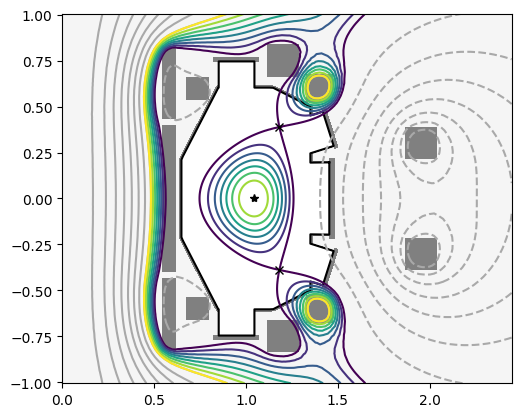

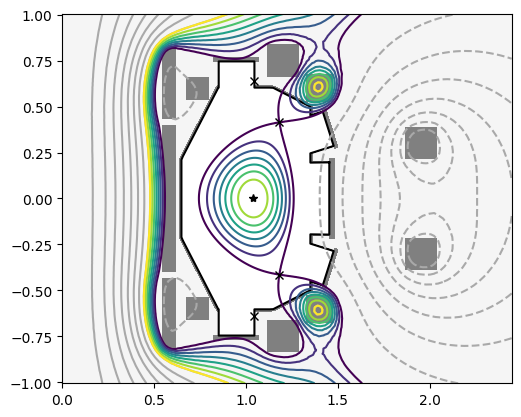

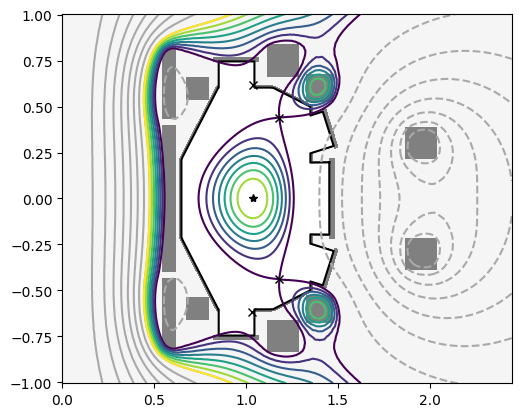

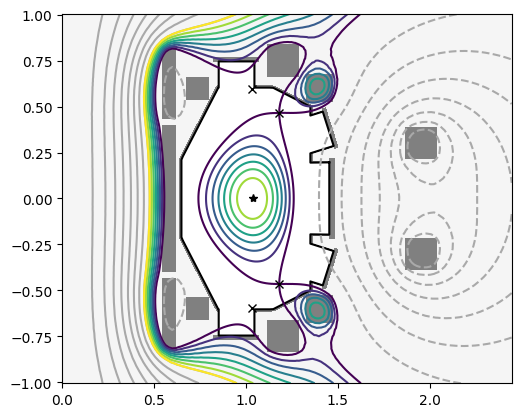

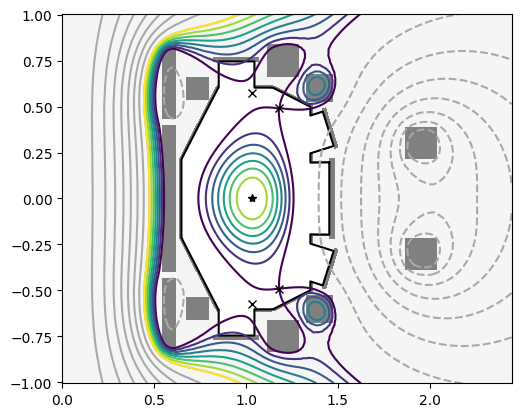

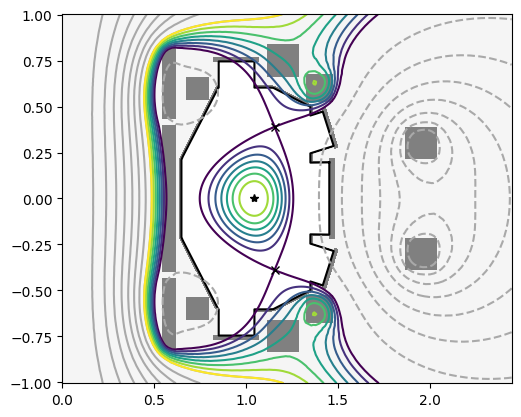

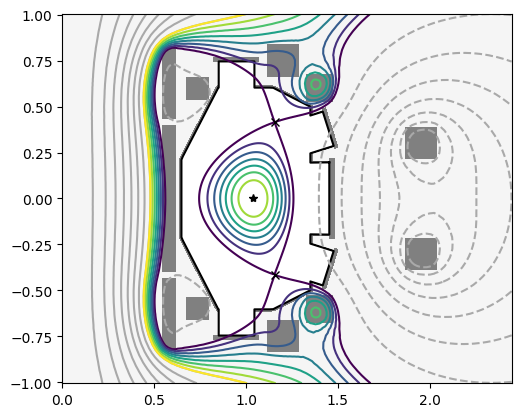

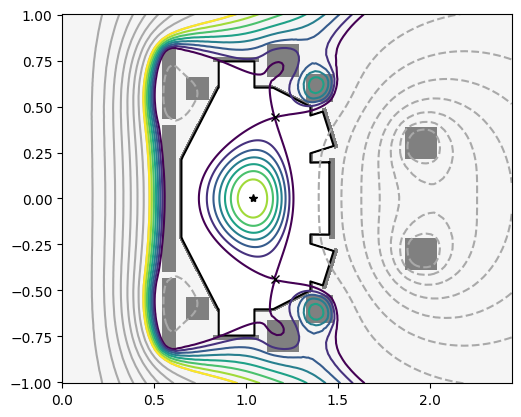

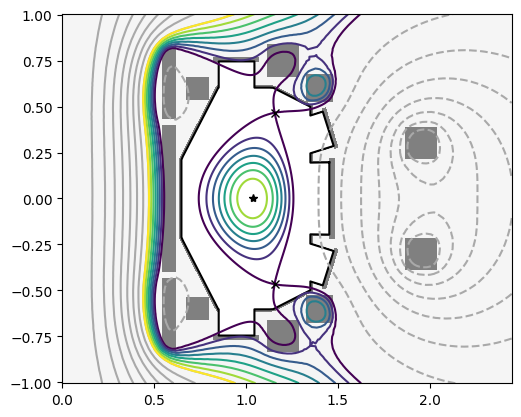

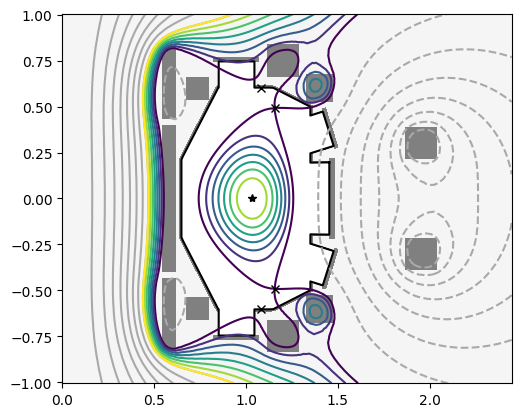

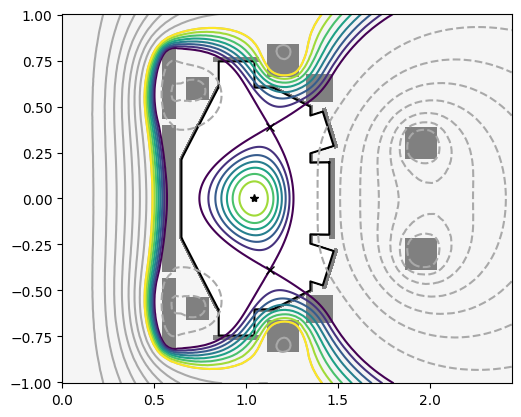

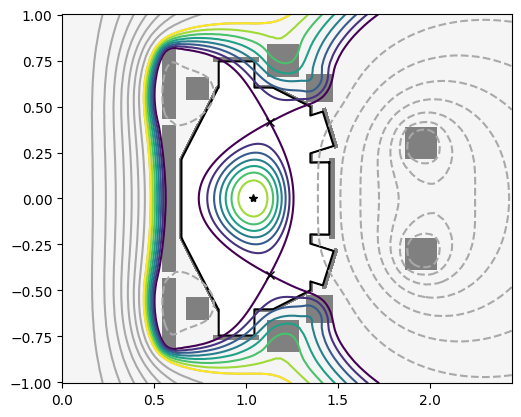

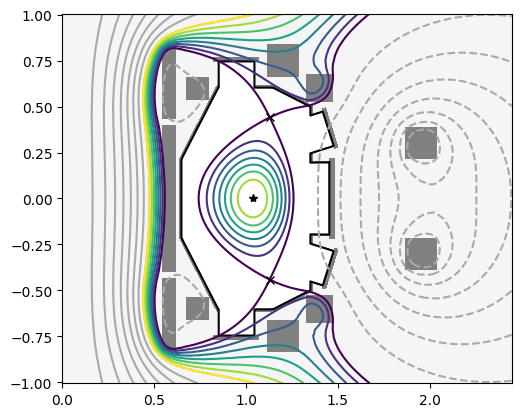

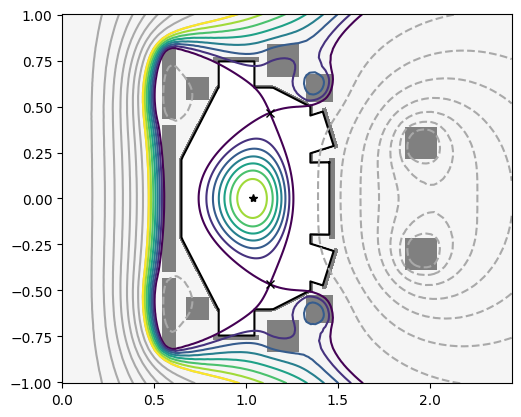

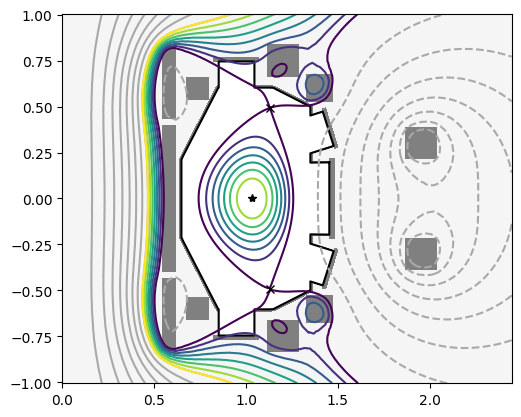

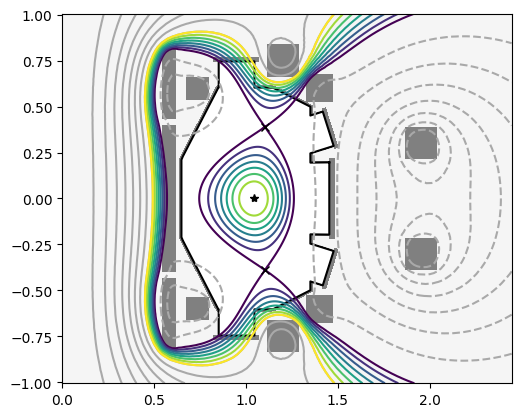

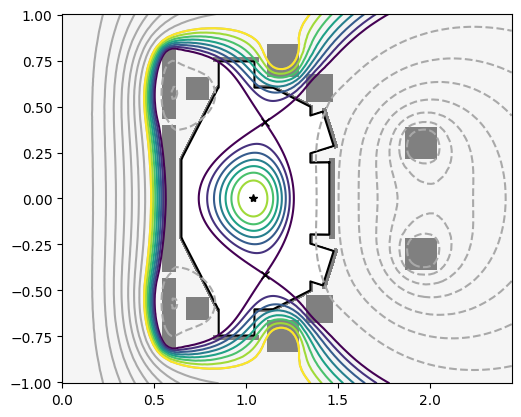

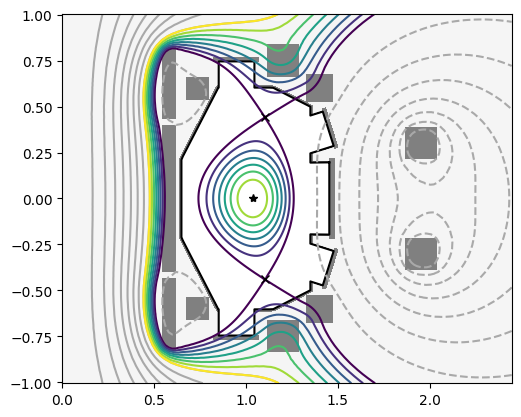

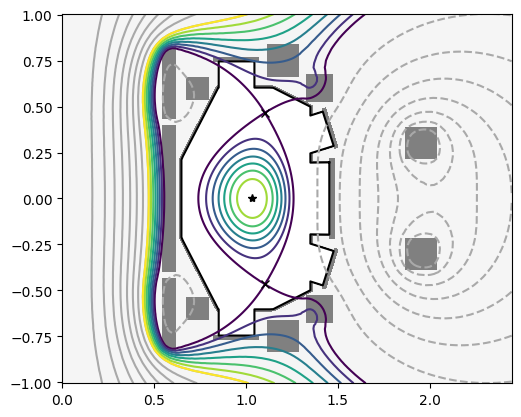

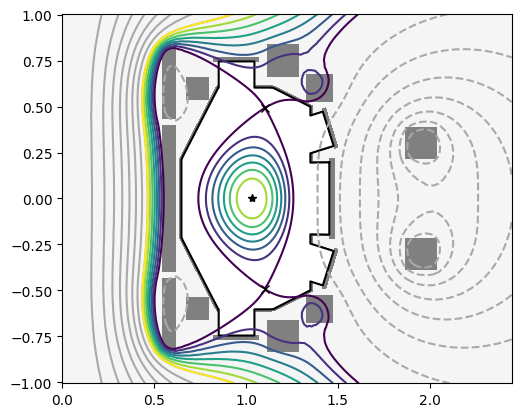

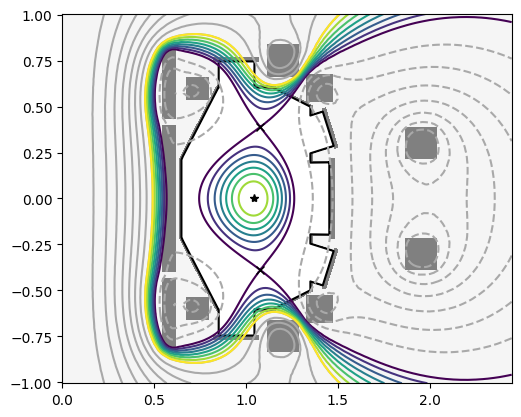

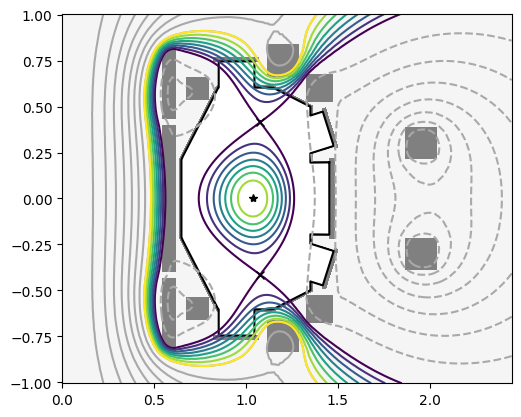

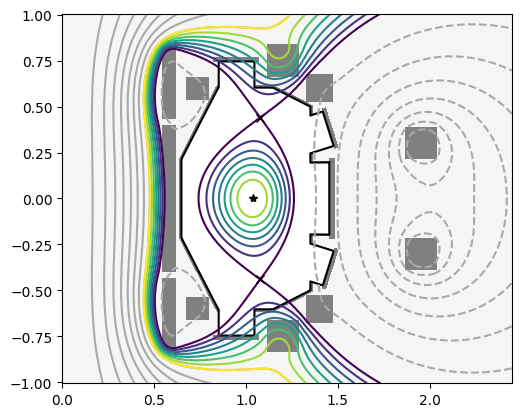

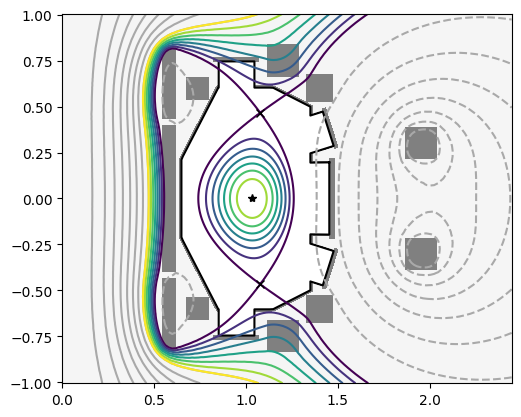

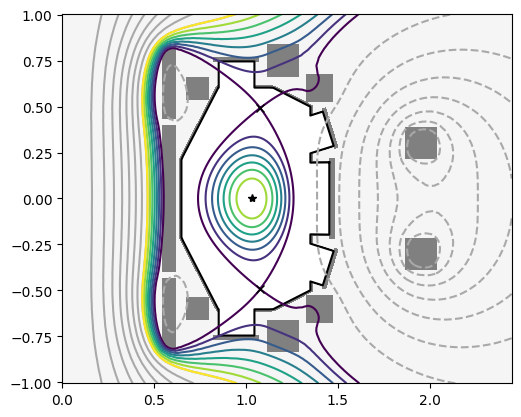

In [3]:
import copy
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
d_out = []
e_out = []
q95 = []

ds = np.linspace(-0.7, -.3, 5)
es = np.linspace(1.5, 1.9, 5)

gammas = []
taus = []



for d in ds: 
    for e in es:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)
        coil_weights[1:3] = 5

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[1,0] = -1
        coil_reg_mat[2,2] = 1
        coil_reg_mat[2,1] = -1

        targets[0] = -3E6

    #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1
        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

    #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

    # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
    # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)



        # set boundary/saddle point targets
        r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        boundary = np.nan_to_num(boundary)
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 30*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 30*np.ones(len(boundary))
        mygs.set_isoflux(boundary, isoflux_weights)

        #find equilibrium
        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        fig,ax = plt.subplots()
        mygs.plot_machine(fig,ax)
        mygs.plot_psi(fig,ax)

 
       

        stats = mygs.get_stats()
        q95.append(stats['q_95'])

        d_out.append(np.min((stats['deltaU'], stats['deltaL'])))
        e_out.append(np.max((stats['kappaU'], stats['kappaL'])))


        eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
        gammas.append(eig_vals[0,0])

        eig_wall, eigvec_wall = mygs.eig_wall()
        taus.append(1/eig_wall[1][0])


        mygs.reset()
        

In [4]:
print(taus)
print(gammas)
print(-np.array(gammas)*.005)

[0.00529707397558806, 0.005297073975588072, 0.00529707397558811, 0.005297073975588092, 0.005297073975588095, 0.005297073975588081, 0.005297073975588078, 0.0052970739755880845, 0.0052970739755880715, 0.005297073975588093, 0.00529707397558809, 0.005297073975588087, 0.005297073975588071, 0.0052970739755880845, 0.005297073975588109, 0.00529707397558808, 0.005297073975588084, 0.005297073975588086, 0.005297073975588094, 0.005297073975588079, 0.005297073975588069, 0.00529707397558808, 0.0052970739755881045, 0.0052970739755880845, 0.005297073975588071]
[-7149.750364333508, -97917.00564077232, 144.83441796913394, 147.52930640167324, 143.54738427845587, -4498.459535335191, -15322.538859725115, 154.63669691495306, 157.6379438496224, 149.38316872529685, -2446.006394187847, -5498.428679955774, -69240.26243192644, 119.88608246271906, 121.39306358010799, -1574.1701392262476, -3220.020209111506, -11951.032695901085, 85.61856202252966, 87.4730360408721, -1061.7526577138342, -2198.876529156798, -6457.51

In [11]:
gt = -np.array(gammas)*.005

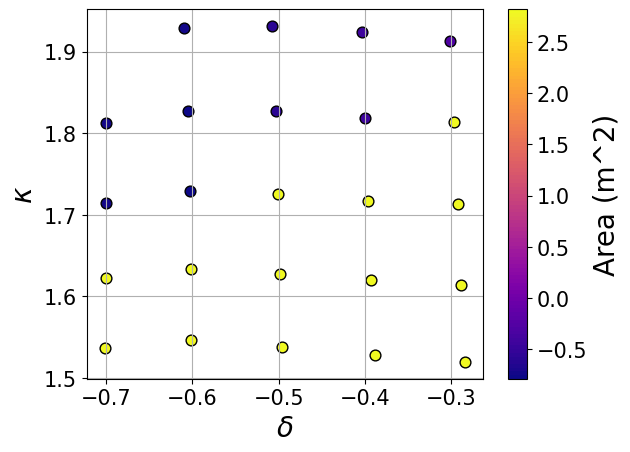

In [6]:

norm = plt.Normalize(np.min(gt), 2.81969624)
cmap = mpl.cm.plasma(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(gt))
for i in range(25):
    if i is not 4:
        plt.scatter(d_out[i], e_out[i], color = c[i], edgecolors = 'k', s = 60)
plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\kappa$', size = 20)
#plt.xlim([-0.7, -0.2])
#plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'Area (m^2)', size = 20)
cb.ax.tick_params(labelsize=15)

In [12]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["pink", "palevioletred", "mediumpurple", "steelblue", "#253494"]
nodes = [0., 0.15, 0.5,0.8,  1]
cmap1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


In [14]:
print(gt)
for i in range(len(gt)):
    if gt[i]<0:
        gt[i] = 100000000

[ 3.57487518e+01  4.89585028e+02 -7.24172090e-01 -7.37646532e-01
 -7.17736921e-01  2.24922977e+01  7.66126943e+01 -7.73183485e-01
 -7.88189719e-01 -7.46915844e-01  1.22300320e+01  2.74921434e+01
  3.46201312e+02 -5.99430412e-01 -6.06965318e-01  7.87085070e+00
  1.61001010e+01  5.97551635e+01 -4.28092810e-01 -4.37365180e-01
  5.30876329e+00  1.09943826e+01  3.22875619e+01  6.38747792e+02
 -3.14589422e-01]


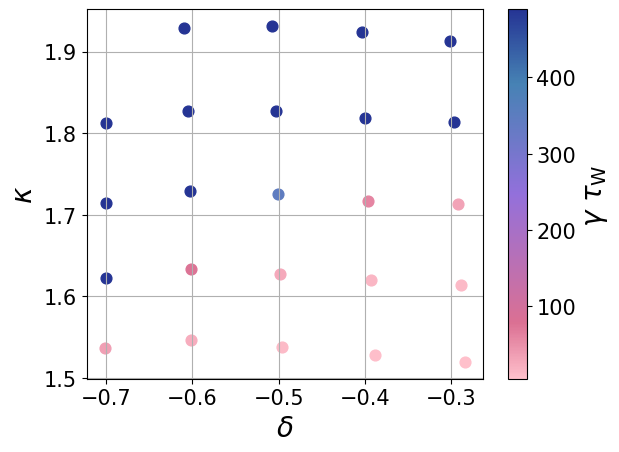

In [15]:

norm = plt.Normalize(5.30876329e+00, 4.89585028e+02)
cmap = mpl.cm.plasma(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap1(norm(gt))
for i in range(25):
    if i is not 4:
        plt.scatter(d_out[i], e_out[i], color = c[i] , s = 60)
plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\kappa$', size = 20)
#plt.xlim([-0.7, -0.2])
#plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap1, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$\gamma$ $\tau_{\mathrm{W}}$ ', size = 20)
cb.ax.tick_params(labelsize=15)